In [78]:
import pandas as pd
from sklearn.metrics import classification_report
#from sklearn.metrics import make_scorer, classification_report, make_scorer, recall, f1, accuracy_score, confusion_matrix
import spacy
from datetime import datetime

nlp = spacy.load('fr_core_news_lg')
stop_words = spacy.lang.fr.stop_words.STOP_WORDS

# loading main df and list of curated reference sentences for each label
train = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "train_fort", index_col = 0)
validation = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "validation_fort", index_col = 0)
test = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "test_fort", index_col = 0)
c_good_value_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_value_curated", index_col=0, header=0).dropna(subset = "text_total")
c_bad_value_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_value_curated", index_col=0, header=0).dropna(subset = "text_total")
c_good_com_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_com_curated", index_col=0, header=0).dropna(subset = "text_total")
c_bad_com_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_com_curated", index_col=0, header=0).dropna(subset = "text_total")
c_good_efficacy_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_efficacy_curated", index_col=0, header=0).dropna(subset = "text_total")
c_bad_efficacy_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_efficacy_curated", index_col=0, header=0).dropna(subset = "text_total")

c_bad_value_curated.head()


,text_total
NaN,argent frais dossier trop important
NaN,Dommage qu'il y ait tant de frais
NaN,m’a pas débité 3 fois la somme je me rend comp...
NaN,171 euros de frais de dossier auxquels je ne ...
NaN,être un piège les frais s'accumuler. les fr...


In [90]:
datetime.now().strftime('%Y-%m-%d %H:%M')

'2024-02-29 00:46'

In [ ]:
# removing stopwords
def stop_word_text_list(text_list):
    liste_filtrée =[]
    round_count = 1
    for review in text_list:
        if round_count % 100 == 0:
            print(f"{round_count} reviews passed of {len(text_list)} - {round(round_count/len(text_list)*100,2)}% done")            
        filtre = []
        try: 
            texte = nlp(review)
            liste_texte = list(texte)
            for word in liste_texte:
                if str(word) not in stop_words:
                    filtre.append(str(word))
            filt_review = (" ".join(filtre))
        except:
            filt_review = ""
        liste_filtrée.append(filt_review)
        round_count = round_count + 1
    return(liste_filtrée)


# labelling decision based on similarity and similarity threshold
def allocate_lab(sim_score, y_pred, thresh):
    #print("thresh", thresh, "sim_score", sim_score)
    try:
        if max(sim_score) > thresh:
            y_pred.append(1)
            #print(max(sim_score), "over threshold", round(thresh,2), "y_pred = 1")
        else:
            y_pred.append(0) 
            #print(max(sim_score), "under threshold", round(thresh,2), "y_pred = 0")
    except:
        y_pred.append(0)
        #print("error, y_pred = 0")
    return y_pred

# classification report
def similarity_report(y,y_pred,f1, recall, precision, thresh):
    report_dic =classification_report(y, y_pred, output_dict=True, zero_division=0)
    f1.append(round(report_dic['macro avg']['f1-score'],2))
    recall.append(round(report_dic['macro avg']['recall'],2))
    precision.append(round(report_dic['macro avg']['precision'],2))
    print(f"threshold: {round(thresh,2)} f1-score: {round(report_dic['macro avg']['f1-score'],2)}")
    return(f1,recall,precision)

def decision_sentiment(sentiment,label_of_interest, word_mode):
    # determining if using stop words or full version of reference texts
    if "stop" in word_mode:
        ref_bag = label_of_interest+"_stop"
    elif "all" in word_mode:
        ref_bag = label_of_interest
    else:
        print("error in word_mode?", word_mode)

    # determining if using sentiment filtered review sentences or all reviews sentences
    if sentiment == True:
        if "good" in label_of_interest:
            if "stop" in word_mode:
                reviews= "text_clean_sentences_pos_stop"
            else:
                reviews =  "text_clean_sentences_pos"
        elif "bad" in label_of_interest:
            if "stop" in word_mode:
                reviews =  "text_clean_sentences_neg_stop"
            else:
                reviews =  "text_clean_sentences_neg"
        else:
            print("mispelling in label_of_interest?", label_of_interest)

    elif sentiment == False:
        # for some reason the original, uncleaned punctuation versions give much better accuracy
        if "stop" in word_mode:
            reviews = "text_stop"
        else:
            reviews = "text_total"
            
    else :
        print("error: no sentiment / granularity found")

    return reviews, ref_bag


    # adapting to new bags
def wrap_final(test_name,label_of_interest,train_test,sentiment,f1,recall,precision, thresh, word_mode, grid):
    if grid:
        best_f1 = max(f1)
        final_thresh = round(test_thresh[f1.index(best_f1)],2)
        final_precision = round(precision[f1.index(best_f1)],2)
        final_recall = round(recall[f1.index(best_f1)],2)
    else:
        best_f1 = f1
        final_thresh = thresh
        final_precision = precision
        final_recall = recall
    
    grid_lab = "grid" if grid else "not grid"
    sentiment_lab = "sentiment" if sentiment else "notSentiment"
    
    temp_report = pd.DataFrame({"label":[label_of_interest],
                            "test": [test_name],
                            "word_mode": [word_mode],
                            "sentiment": sentiment_lab,
                            "f1": best_f1,
                            "precision":final_precision,
                            "recall": final_recall,
                            "used/optimal_threshold": [final_thresh],
                            "grid": grid_lab,
                            "train_valid_test": [train_test],
                            "time": datetime.now().strftime('%Y-%m-%d %H:%M')})
    temp_report.to_csv(f"../reports/similarity/raw/{train_test}_{test_name}_{label_of_interest}_{grid_lab}_{sentiment_lab}_{word_mode}.csv")
    

In [77]:
time.time()

1709163523.919692

In [25]:
# joining all reference curated review strings 

#bags with regeference text for each label
bag_good_value = nlp(" ".join([message for message in c_good_value_curated.text_total]))
bag_bad_value = nlp(" ".join([message for message in c_bad_value_curated.text_total]))
bag_good_com = nlp(" ".join([message for message in c_good_com_curated.text_total]))
bag_bad_com = nlp(" ".join([message for message in c_bad_com_curated.text_total]))
bag_good_efficacy = nlp(" ".join([message for message in c_good_efficacy_curated.text_total]))
bag_bad_efficacy = nlp(" ".join([message for message in c_bad_efficacy_curated.text_total]))

# making stop word versions of our reference documents
bag_good_com_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_com_curated.text_total)]))
bag_bad_com_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_com_curated.text_total)]))
bag_good_value_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_value_curated.text_total)]))
bag_bad_value_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_value_curated.text_total)]))
bag_good_efficacy_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_efficacy_curated.text_total)]))
bag_bad_efficacy_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_efficacy_curated.text_total)]))

# also creating df / col versions (easier to call from functions)
references = pd.DataFrame({"c_good_efficacy": [bag_good_efficacy],
"c_bad_efficacy": [bag_bad_efficacy] ,
"c_good_com": [bag_good_com],
"c_bad_com": [bag_bad_com] ,
"c_good_value": [bag_good_value],
"c_bad_value": [bag_bad_value],
"c_good_efficacy_stop": [bag_good_efficacy_stop],
"c_bad_efficacy_stop": [bag_bad_efficacy_stop] ,
"c_good_com_stop": [bag_good_com_stop],
"c_bad_com_stop": [bag_bad_com_stop] ,
"c_good_value_stop": [bag_good_value_stop],
"c_bad_value_stop": [bag_bad_value_stop]})

# creating the range of similarity thresholds to try
import numpy as np
test_thresh = np.arange(0.68,0.96, 0.01)


100 reviews passed of 152 - 65.79% done
100 reviews passed of 152 - 65.79% done
100 reviews passed of 152 - 65.79% done
100 reviews passed of 152 - 65.79% done


In [153]:
# Creating functions to try three text granularity 

# Comparing whole review vs whole reference bag
def review_vs_whole_ref_bag(df,label_of_interest, sentiment, thresh, train_test, word_mode, grid):
    test_name = "review_vs_whole_ref_bag"
    print("passing",test_name)
    f1, recall, precision, y_pred = [],[],[],[]
    y = df[label_of_interest]
    # establish the correct review granularity, review and reference pieces to integrate based on sentiment bool, stop_word (word_mode) bool and label of interest
    reviews,ref_bag = decision_sentiment(sentiment,label_of_interest, word_mode) 
    print("for label", label_of_interest)
    print("review colname", reviews)
    print("reference bag colname", ref_bag)
    ref_bag = nlp(references[ref_bag][0]) # we convert the references once to nlp before the loop
    def looping():
        y_pred = []
        for review in df[reviews]: # take each full review
            sim_score = []
            try:
                review = nlp(review)
                sim_score.append(round(ref_bag.similarity(review),2)) # compare it with the full reference bag
                allocate_lab(sim_score, y_pred, thresh) # if similarity score is > than threshold we append 1, otherwise: 0
            except: # if similarity test fails, we put 0 (in this case na or non text review)
                #print("nan or error on message:", review)
                y_pred.append(0)
        return y_pred
        
    #print("len y",len(y), "len y_pred",len(y_pred), "len reviews", len(reviews))
    if grid: # if we chose to run the function on all the range of threshold
        for thresh in thresh:
            y_pred = looping()
            f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    else: # if we chose a one shot similarity test for a give threshold, i.e 0.83
        y_pred = looping()
        f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    # we consolidate results into a df and export as a csv
    wrap_final(test_name,label_of_interest,train_test, sentiment, f1,recall,precision,thresh, word_mode, grid)
    if grid == False:
        return y_pred 
    if grid:
        return f1

# comparing review sentences vs whole reference bag
def review_sentence_vs_whole_ref_bag(df,label_of_interest, sentiment, thresh, train_test, word_mode, grid):
    test_name = "review_sentence_vs_whole_ref_bag"
    print("passing",test_name)
    y = df[label_of_interest]
    f1, recall, precision, y_pred = [],[],[],[]
    reviews,ref_bag = decision_sentiment(sentiment,label_of_interest, word_mode)
    print("for label", label_of_interest)
    print("reviews column:",reviews)
    print("references column:", ref_bag)
    ref_bag = nlp(references[ref_bag][0])
    def looping():
        y_pred = []
        for review in df[reviews]:
            sim_score = []
            try:
                review = nlp(review)
                review_sentences = review.sents
                for review_sentence in review_sentences:
                    if len(review_sentence) > 1:
                        temp_sim_score = round(ref_bag.similarity(review_sentence),2)
                        sim_score.append(temp_sim_score)
                    #else:
                        #print("passing since sentence is < 1 token", review_sentence)
            except:
                sim_score.append(0.0)
                #print("message null")
            y_pred = allocate_lab(sim_score, y_pred, thresh)
        return y_pred

    if grid:
        for thresh in thresh:
            y_pred  = looping()
            f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    else:
        y_pred = looping()
        f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    print(y_pred)
    wrap_final(test_name,label_of_interest,train_test, sentiment, f1,recall,precision,thresh, word_mode, grid)
    print("label", label_of_interest, "detected corpus", reviews)
    if grid == False:
        return y_pred 
    if grid:
        return f1

# Comparing review sentences vs reference bag sentences
def review_sentence_vs_ref_sentence(df,label_of_interest, sentiment, thresh, train_test, word_mode, grid):
    test_name = "review_sentence_vs_ref_sentence"
    print("passing",test_name)
    y = df[label_of_interest]    
    f1, recall, precision, y_pred = [],[],[],[]
    reviews,ref_bag = decision_sentiment(sentiment,label_of_interest, word_mode)
    ref_bag = nlp(references[ref_bag].iloc[0])
    def looping():
        y_pred = []
        for review in df[reviews]: 
            sim_score = []
            try:
                review = nlp(review)
                review_sentences = review.sents
                for review_sentence in review_sentences: # take each review sentence
                    if len(review_sentence) > 1:
                        for sentence_exemple in ref_bag.sents:
                            temp_sim_score = round(sentence_exemple.similarity(review_sentence),2) # test similarity with whole reference bag
                            sim_score.append(temp_sim_score)
            except:
                #print("message null")
                sim_score.append(0.0)
            y_pred = allocate_lab(sim_score, y_pred, thresh) # if similarity failed, mark as 0 (empty review or not sentence aligned with label sentiment if sentiment = True)     

        print(y_pred)
        return y_pred

    if grid: # if grid we repeat for each threshold of the custom range
        for thresh in thresh:
            y_pred= looping()
            f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)         
            
    else: # if not a grid, we do a one shot using the fixed threshold
        y_pred = looping()
        f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
        
    wrap_final(test_name,label_of_interest,train_test, sentiment, f1,recall,precision,thresh, word_mode, grid)
    print("label", label_of_interest, "detected corpus", reviews, "y pred:", y_pred)
    if grid == False:
        return y_pred 
    if grid:
        return f1


passing review_vs_whole_ref_bag
for label c_bad_com
review colname text_clean_sentences_neg_stop
reference bag colname c_bad_com_stop
threshold: 0.68 f1-score: 0.6555585177286057
threshold: 0.6900000000000001 f1-score: 0.6377908606672273
threshold: 0.7000000000000001 f1-score: 0.6497695852534562
threshold: 0.7100000000000001 f1-score: 0.6497695852534562
threshold: 0.7200000000000001 f1-score: 0.6112531969309464
threshold: 0.7300000000000001 f1-score: 0.5985594237695078
threshold: 0.7400000000000001 f1-score: 0.5985594237695078
threshold: 0.7500000000000001 f1-score: 0.5645433097404786
threshold: 0.7600000000000001 f1-score: 0.5435435435435436
threshold: 0.7700000000000001 f1-score: 0.5303525990548892
threshold: 0.7800000000000001 f1-score: 0.5303525990548892
threshold: 0.7900000000000001 f1-score: 0.5303525990548892
threshold: 0.8000000000000002 f1-score: 0.5303525990548892
threshold: 0.8100000000000002 f1-score: 0.5066308077529444
threshold: 0.8200000000000002 f1-score: 0.506630807752

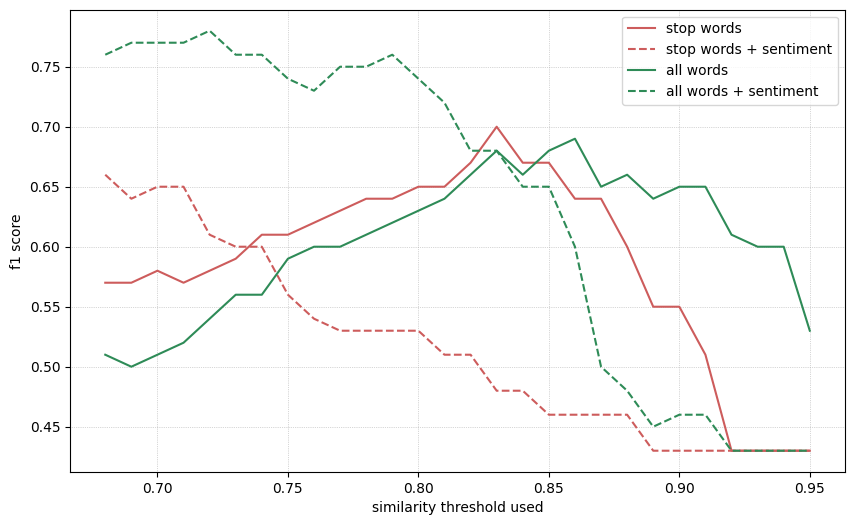

In [154]:
# testing using all words vs without stop words with one method: full review vs full ref for good efficacy label

baseline_stop_words_sents = review_vs_whole_ref_bag(train,"c_bad_com", True, test_thresh, "train", "stopwords", True) # with sentiment (bool #1) and filtered stopwords (bool #2)
baseline_stop_words = review_vs_whole_ref_bag(train,"c_bad_com", False, test_thresh, "train", "stopwords", True) # without sentiment (bool #1) and filtered stopwords (bool #2)
baseline_all_words_sents = review_vs_whole_ref_bag(train,"c_bad_com", True, test_thresh, "train", "allwords", True) # without sentiment (bool #1) and without filtered stopwords (bool #2)
baseline_all_words = review_vs_whole_ref_bag(train,"c_bad_com", False, test_thresh, "train", "allwords", True) # with sentiment (bool #1) and filtered stopwords (bool #2)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(test_thresh,baseline_stop_words, label ="stop words", color ="indianred")
plt.plot(test_thresh,baseline_stop_words_sents, label ="stop words + sentiment", color ="indianred",linestyle="--")
plt.plot(test_thresh, baseline_all_words, label = "all words", color="seagreen")
plt.plot(test_thresh, baseline_all_words_sents, label ="all words + sentiment", linestyle="--", color="seagreen")
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.xlabel("similarity threshold used")
plt.ylabel("f1 score")
plt.legend()
plt.show();

Adding a sentiment filter to our process can sometimes increase our text sentiment similarity accuracy, in this specific case in a context of lower chosen similarity threshold, which would normally produce too many positives, including false.
the sentiment filter helps when strings are very close semantically but belong to opposite labels. For instance in the case of Bad efficacy and Good efficacy: "comunication with the bank was terrible", "comunication with the bank was great" share a lot of semantic similarity except for the sentiment "great"/"terrible".

We will test both stop words and full words in similarity matching: 
Running similarity grids to test best granularity (sentence vs whole text; ref as whole ref, as sentence or replaced by keywords) for STOP words

In [ ]:

def meta_grid(df, label_of_interest, thresh_list, train_test):
    # With Sentiment ####
    ## all words
    review_vs_whole_ref_bag(df,label_of_interest, True, thresh_list, train_test, "allwords", True)
    review_sentence_vs_whole_ref_bag(df,label_of_interest, True, thresh_list, train_test, "allwords", True)
    review_sentence_vs_ref_sentence(df,label_of_interest, True,  thresh_list, train_test, "allwords", True)
    # stop words
    review_vs_whole_ref_bag(df,label_of_interest, True, thresh_list, train_test, "stopwords", True)
    review_sentence_vs_whole_ref_bag(df,label_of_interest, True, thresh_list, train_test, "stopwords", True)
    review_sentence_vs_ref_sentence(df,label_of_interest, True, thresh_list, train_test, "stopwords", True)

    # Without Sentiment ####
    ## allwords
    review_vs_whole_ref_bag(df,label_of_interest, False, thresh_list, train_test, "allwords",True)
    review_sentence_vs_whole_ref_bag(df,label_of_interest, False, thresh_list, train_test, "allwords", True)
    review_sentence_vs_ref_sentence(df,label_of_interest, False, thresh_list, train_test, "allwords", True)
    ##stopwords
    review_vs_whole_ref_bag(df,label_of_interest, False, thresh_list, train_test, "stopwords", True)
    review_sentence_vs_whole_ref_bag(df,label_of_interest, False, thresh_list, train_test, "stopwords", True)
    review_sentence_vs_ref_sentence(df,label_of_interest, False, thresh_list, train_test, "stopwords", True)

labels = ["c_good_com",'c_bad_com',"c_good_efficacy", "c_bad_efficacy", "c_good_value", "c_bad_value"]

for label_of_interest in labels:
    meta_grid(train, label_of_interest, test_thresh, "train")

Let's make a heatmap to see the F1 Scores of the different methods

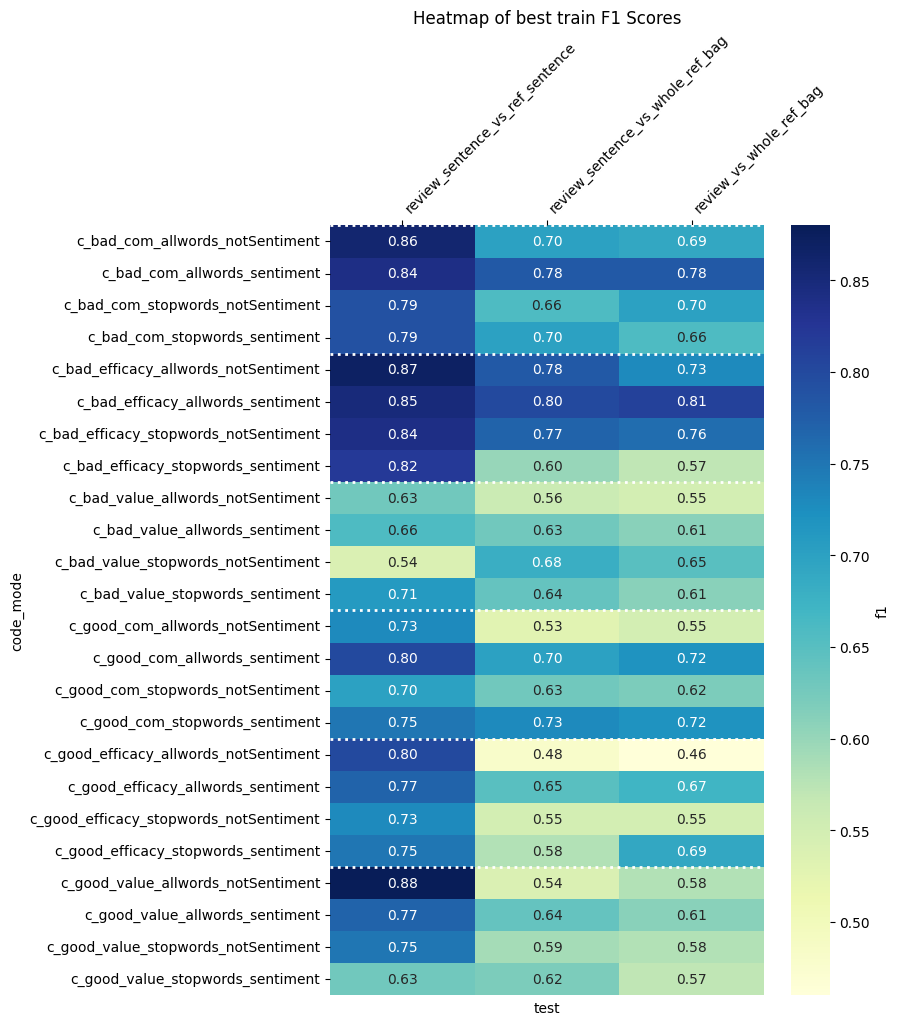

In [143]:
from os import listdir
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# compile the grid results
def compile_benchmarks (test_train, grid):
    bench_list = listdir("../reports/similarity/raw")
    try: 
        bench_list.remove(".DS_Store")
    except:
        print("error in remove")
        
    bench_list = [path for path in bench_list if "baseline" not in path]
    bench_list = [path for path in bench_list if test_train in path]
    
    benchmark = pd.DataFrame()
    for file in bench_list:
        df = pd.read_csv(f'../reports/similarity/raw/{file}', index_col=0)
        benchmark = pd.concat([benchmark, df])
    benchmark = benchmark.sort_values("f1", ascending = False)
    benchmark['code_mode'] = benchmark.label + "_" + benchmark['word_mode'] + "_" + benchmark['sentiment']
    if grid:
        benchmark = benchmark[benchmark.grid == "grid"]
    else:
        benchmark = benchmark[benchmark.grid == "not grid"]
    return benchmark

# make a heat map of the best f1 scores
def heat(train_test):
    # pivot table heatmap
    pivot = benchmark.pivot_table(index='code_mode', columns='test', values='f1')
    plt.figure(figsize=(7, 10))  
    heatmap = sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0, linecolor='grey')

    # horizontal lines 
    for i in range(0, len(pivot.index), 4):
        plt.axhline(i, color='white', linestyle=':', linewidth=2)

    # Label the color bar
    color_bar = heatmap.collections[0].colorbar
    color_bar.set_label('f1')

    plt.title(f'Heatmap of best {train_test} F1 Scores')
    heatmap.xaxis.tick_top() 
    plt.xticks(rotation=45, ha='left') 
    plt.show()
# call the compiler and heatmap functions
benchmark = compile_benchmarks("train", True)
heat("train")

The heatmap shows strong train accuracy results, mostly when comparing data sentence to reference label sentence.
**all words** often yield higher accuracy scores than **removing stopwords** for the training data scores, but the difference is minimal. 
a top parameters table will be handy at this stage.

In [144]:
best_params = pd.DataFrame()
def compile_best_params(label,best_params):
    code_df = benchmark[benchmark['label'] == label]
    best_threshold_index = code_df['f1'].idxmax()
    best_threshold = code_df['used/optimal_threshold'].iloc[best_threshold_index]
    best_method = code_df['test'].iloc[best_threshold_index]
    best_accuracy = code_df['f1'].iloc[best_threshold_index]
    best_mode = code_df['word_mode'].iloc[best_threshold_index]
    train_test = code_df['train_valid_test'].iloc[best_threshold_index]
    sentiment = code_df['sentiment'].iloc[best_threshold_index]
    grid = code_df['grid'].iloc[best_threshold_index]

    temp_df = pd.DataFrame({
        "label": [label],
        "train_valid_test" :[train_test],
        "Accuracy": [best_accuracy],
        "best_threshold": [best_threshold],
        "Method": [best_method],
        "Word mode": [best_mode],
        "Sentiment": [sentiment],
        "Grid": [grid]
    })
    best_params = pd.concat([best_params, temp_df], ignore_index= True)
    return best_params
label_names = set(benchmark["label"])
for label in label_names:
    best_params = compile_best_params(label,best_params)
best_params


,label,train_valid_test,Accuracy,best_threshold,Method,Word mode,Sentiment,Grid
0,c_good_efficacy,train,0.80,0.87,review_sentence_vs_ref_sentence,allwords,notSentiment,grid
1,c_bad_com,train,0.86,0.92,review_sentence_vs_ref_sentence,allwords,notSentiment,grid
2,c_bad_value,train,0.71,0.77,review_sentence_vs_ref_sentence,stopwords,sentiment,grid
3,c_bad_efficacy,train,0.87,0.92,review_sentence_vs_ref_sentence,allwords,notSentiment,grid
4,c_good_com,train,0.80,0.79,review_sentence_vs_ref_sentence,allwords,sentiment,grid
5,c_good_value,train,0.88,0.89,review_sentence_vs_ref_sentence,allwords,notSentiment,grid


**The better F1 Scores** were obtained using:
* Review sentence vs reference sentences with all words:
    * allwords:
        * without sentiment:
            * good efficacy (0.80)
            * bad communication (0.86)
            * bad efficacy (0.87)
            * good value (0.88)
        * with sentiment:
            * good comuunication (0.80)
    * with filtered stop words:
        * with sentiment:
            * bad value (0.71)
     (c_good_com_allwords **.69**),

Overall train results are quite good, except with the bad value label which is medium, at 0.71, but still nearly 5x compared to random labelling.



These results are based on the training dataset, we will run the best parameters on the **validation** dataset to see how our scores handle unseen data.

To do that, we will extract the **optimal parameters** (document granularity, all word/stopwords, optimal threshold) to run the labelling on the test and then on the larger dataset in the best available conditions.

In [166]:
# save best parameters
best_params.to_csv('../reports/similarity/best_params.csv')

# check selected methods
set(best_params.Method)

{'core_review_sentence_vs_reference_sentence',
 'core_review_sentence_vs_whole_ref_bag'}

# Validation

We'll try the best text similarity parameters from the training round for one shot labeling

In [1]:
review_sentence_vs_ref_sentence(validation,"c_good_efficacy", False, 0.79, "validation", "allwords", False)
review_sentence_vs_ref_sentence(validation,"c_bad_com", False, 0.85, "validation", "allwords", False)
review_sentence_vs_whole_ref_bag(validation,"c_bad_value", True, 0.69, "validation", "stopwords", False)
review_vs_whole_ref_bag(validation,"c_bad_efficacy", False, 0.91, "validation", "allwords", False)
review_sentence_vs_ref_sentence(validation,"c_good_com", False, 0.79, "validation", "allwords", False)
review_sentence_vs_whole_ref_bag(validation,"c_good_value", False, 0.88, "validation", "allwords", False)

NameError: name 'review_sentence_vs_ref_sentence' is not defined

In [116]:
benchmark= compile_benchmarks("validation", False)
benchmark

,label,test,word_mode,sentiment,f1,precision,recall,used/optimal_threshold,grid,train_valid_test,time,code_mode
0,c_bad_value,review_sentence_vs_whole_ref_bag,stopwords,sentiment,0.78,0.97,0.71,0.69,not grid,validation,2024-02-29 11:35,c_bad_value_stopwords_sentiment
0,c_bad_com,review_sentence_vs_ref_sentence,allwords,notSentiment,0.69,0.68,0.71,0.85,not grid,validation,2024-02-29 11:35,c_bad_com_allwords_notSentiment
0,c_bad_efficacy,review_vs_whole_ref_bag,allwords,notSentiment,0.64,0.79,0.65,0.91,not grid,validation,2024-02-29 11:35,c_bad_efficacy_allwords_notSentiment
0,c_good_value,review_sentence_vs_whole_ref_bag,allwords,notSentiment,0.60,0.71,0.57,0.88,not grid,validation,2024-02-29 11:35,c_good_value_allwords_notSentiment
0,c_good_com,review_sentence_vs_ref_sentence,allwords,notSentiment,0.37,0.51,0.53,0.79,not grid,validation,2024-02-29 11:35,c_good_com_allwords_notSentiment
0,c_good_efficacy,review_sentence_vs_ref_sentence,allwords,notSentiment,0.33,0.43,0.39,0.79,not grid,validation,2024-02-29 11:35,c_good_efficacy_allwords_notSentiment


The results are not optimal, we will run a grid search to find better thresholds for the validation set

In [ ]:
for label_of_interest in labels:
    meta_grid(validation, label_of_interest, test_thresh, "validation")

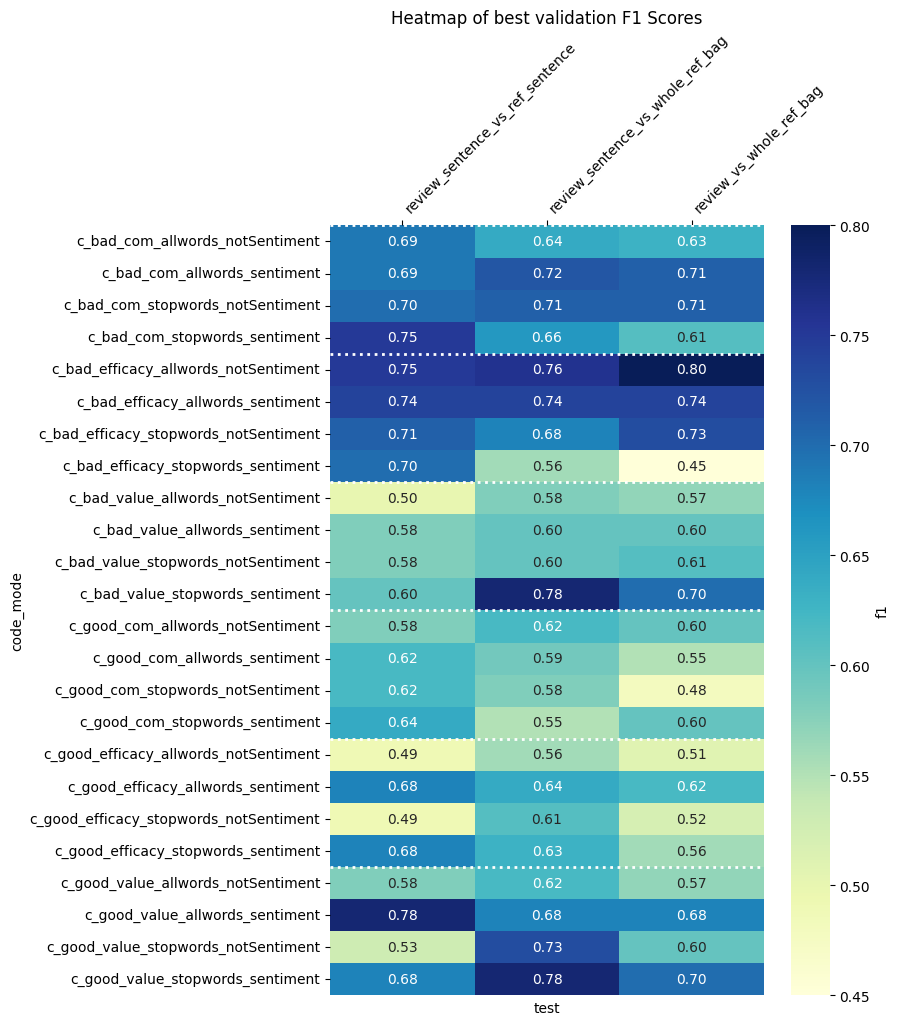

In [106]:
benchmark = compile_benchmarks("validation", True)
heat("validation")

In [147]:
# list the best parameters
label_names = set(benchmark["label"])
best_params = pd.DataFrame()
for label in label_names:
    best_params = compile_best_params(label,best_params)
best_params

,label,train_valid_test,Accuracy,best_threshold,Method,Word mode,Sentiment,Grid
0,c_good_efficacy,test,0.60,0.71,review_sentence_vs_ref_sentence,stopwords,sentiment,not grid
1,c_bad_com,test,0.80,0.73,review_sentence_vs_ref_sentence,stopwords,sentiment,not grid
2,c_bad_value,test,0.54,0.69,review_sentence_vs_whole_ref_bag,stopwords,sentiment,not grid
3,c_bad_efficacy,test,0.71,0.86,review_vs_whole_ref_bag,allwords,notSentiment,not grid
4,c_good_com,test,0.60,0.68,review_sentence_vs_ref_sentence,stopwords,sentiment,not grid
5,c_good_value,test,0.57,0.68,review_sentence_vs_whole_ref_bag,stopwords,sentiment,not grid


The resulting scores are closer to those from the training benchmark, interestingly for several labels the optimal threshold has been lowered, this is expected since the reference documents were created from the training data and our algorithm now faces unseen data, with less obvious simililarities. Moreover, using sentiment and stopwords filters haas been prefered for all labels except one. The value of these filters has increased with unseen data.

We will now proceed to the test phase, by using the thresholds found to be optimal in the validation phase. We added the validation phase as an intermerdiary that would allow to find optimal thresholds to unseen data and still have another round, the test, to evaluate these lower fixed thresholds without seeking optimal thresholds, to get a sense of how well our system would fare when labelling the rest of the dataset. 

# TEST

In [ ]:
review_sentence_vs_ref_sentence(test,"c_good_efficacy", True, 0.71, "test", "stopwords", False)
review_sentence_vs_ref_sentence(test,"c_bad_com", True, 0.73, "test", "stopwords", False)
review_sentence_vs_whole_ref_bag(test,"c_bad_value", True, 0.69, "test", "stopwords", False)
review_vs_whole_ref_bag(test,"c_bad_efficacy", False, 0.86, "test", "allwords", False)
review_sentence_vs_ref_sentence(test,"c_good_com", True, 0.68, "test", "stopwords", False)
review_sentence_vs_whole_ref_bag(test,"c_good_value", True, 0.68, "test", "stopwords", False)

In [145]:
benchmark= compile_benchmarks("test", False)
label_names = set(benchmark["label"])
best_params = pd.DataFrame()
for label in label_names:
    best_params = compile_best_params(label,best_params)
best_params

,label,train_valid_test,Accuracy,best_threshold,Method,Word mode,Sentiment,Grid
0,c_good_efficacy,test,0.60,0.71,review_sentence_vs_ref_sentence,stopwords,sentiment,not grid
1,c_bad_com,test,0.80,0.73,review_sentence_vs_ref_sentence,stopwords,sentiment,not grid
2,c_bad_value,test,0.54,0.69,review_sentence_vs_whole_ref_bag,stopwords,sentiment,not grid
3,c_bad_efficacy,test,0.71,0.86,review_vs_whole_ref_bag,allwords,notSentiment,not grid
4,c_good_com,test,0.60,0.68,review_sentence_vs_ref_sentence,stopwords,sentiment,not grid
5,c_good_value,test,0.57,0.68,review_sentence_vs_whole_ref_bag,stopwords,sentiment,not grid


Our test results vary depending on label, for **bad communication** we retain a high precision score (0.80), **bad efficacy (0.71)**, **good efficacy (0.60)** and **good communication (0.60)** have lost some accuracy, **good value (0.57)** and **bad value (0.54)** have the lowest accuracy scores. This may be due to several factors: first, the value labels and available training data were less numerous than other labels, simply put, users tend to talk more about miscommunication and inefficiency than economic value of their banking service. Moreover, the internal coherence of the value labels may be lower: we decided to include sentences which discussed fees, interest rates, aquired or rejected loans: but the variety of topics may make the lable more prone to false neggatives and positives, even if some specific words surch as "euros" (we converted all € into "euros"), "prêt", "débiter" could in theory trigger similarity matches. In practice the results are less clear.

One option would be to relabel and exclude some of the topics, for instance loan aquicisition. Another option would be to give more weight to key terms, one simple way in our system would be to repeat these words when found in reference and review sentences, another would be to increase the simularity score of sentences where they are found, possibly running a grid search to find the optimal bonus points for better accuracy ... Another option would be to hardcode keyword based filters to include or exclude messages. While this is beyond the scope of the current project, to pick a strategy and have a better idea of how the similarity test fails it would be worthwhile to retrieve reviews which triggered false positive and false negatives and get a fine understanding of the issue. 

more broadly, **results could be improved** by:
* **Labelling more messages** to make more robust training dataset. 
    * If the selection of the labels reference sentences becomes tedious with larger sets, it could be automated by running **TF/IDF** between the reference documents and only keeping words which are prevalent, relevant and specific to each. For this smaller subset I prefered to rely on my own judgment and experience in qualitative research to select best sentences.
* Using a **stronger deep learning models like Camembert** (or BERT for English): for finer semantic text similarity. Here we used fr_core_news_lg which has less parameters but can be conveniently used within spaCy.
    
That being said, with six classes, and considering value lables are the minority classes of the dataset, we still have a 3.5x higher accuracy than random labelling (around .15 vs .54), we will proceed with the labelling of the dataset but will keep in mind the accuracy limitations of the weaker labels.

In [146]:
# saving best parameters for the dataset labelling
best_params.to_csv('../reports/similarity/best_validation_params.csv')